# Librairies

In [1]:
from openclassrooms.p6 import *
import ast, os, warnings
from tqdm import tqdm
from random import seed

import tensorflow_hub as hub
import tensorflow

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import set_config

# Config

In [2]:
STORAGE_PATH = '../data'
file_name = "data.csv"

seed(0)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 500)
warnings.filterwarnings('ignore')
set_config(display="diagram")

# Data

In [3]:
data = pd.read_csv(os.path.join(STORAGE_PATH, file_name))

preprocessing_stages = ['tokens', 'tokens_sw', 'tokens_swa', 'tokens_sw_tag', 'tokens_swa_tag']

for stage in preprocessing_stages:
    data[stage] = data[stage].apply(ast.literal_eval)

# Universal Sentence Encoder

In [4]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

descriptions_vectors = UniversalSentenceEncoder(use).fit_transform(data.description)
product_names_vectors = UniversalSentenceEncoder(use).fit_transform(data.product_name)
descriptions_and_product_names_vectors = UniversalSentenceEncoder(use).fit_transform(data.product_name + '. ' + data.description)

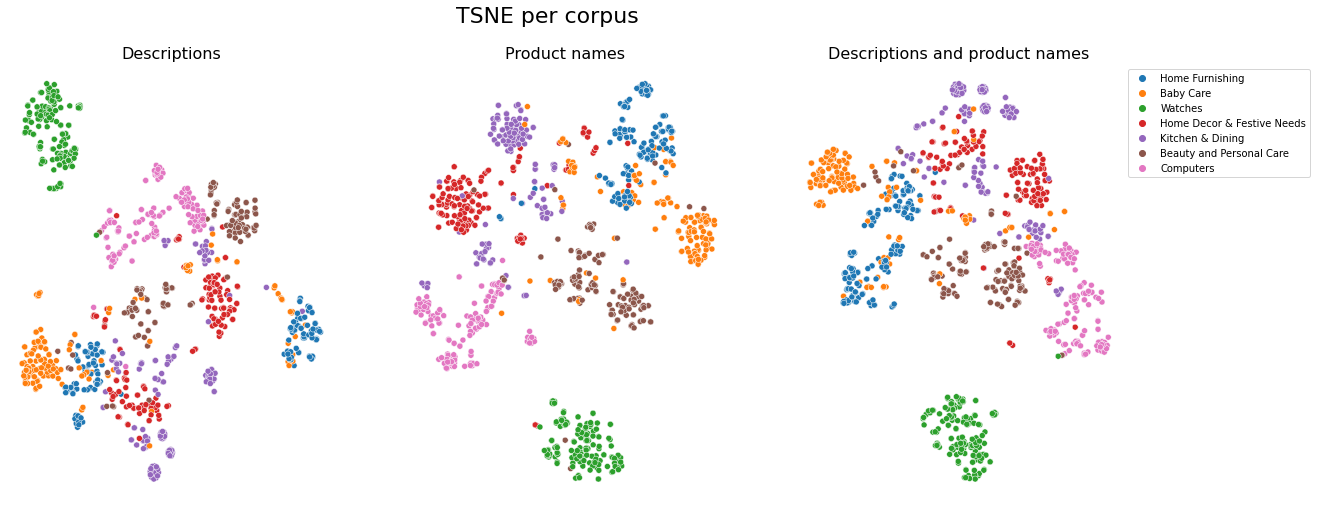

In [5]:
y = data.category_0

plt.figure(figsize=(20, 8))
plt.suptitle('TSNE per corpus', size=22)

corpus_list = ['descriptions', 'product_names', 'descriptions_and_product_names']

for i, corpus in enumerate(corpus_list):
    plt.subplot(1, 3, i+1)
    legend = False if i < 2 else True
    plot_TSNE(locals()[corpus + '_vectors'], y, axis='off', legend=legend, title=corpus.replace('_', ' ').capitalize())

plt.show()

# Classification

## Supervized approach

In [5]:
y = data.category_0

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)

param_grid = {
    'corpus__columns' : [['description'], ['product_name'], ['product_name', 'description']],
    'PCA__ratio': [0.90, 0.95, 0.99, None]
}

pipe = Pipeline(steps=[
    ('corpus', CorpusSelector(columns=None)),
    ('vectorizer', UniversalSentenceEncoder(use)),
    ('PCA', CustomPCA()),
    ('classifier',  RandomForestClassifier(random_state=0))
])

display(pipe)

Pipeline(steps=[('corpus', CorpusSelector(columns=None)),
                ('vectorizer',
                 UniversalSentenceEncoder(model=<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f025014c450>)),
                ('PCA', CustomPCA()),
                ('classifier', RandomForestClassifier(random_state=0))])

In [6]:
results = pd.DataFrame()

for parameters in tqdm(ParameterGrid(param_grid)):
    
    pipe = pipe.set_params(**parameters)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    results = results.append({'score': score, 'parameters': parameters} , ignore_index=True)

100%|██████████| 12/12 [00:29<00:00,  2.50s/it]


In [7]:
best_results_parameters = results.loc[results.score == results.score.max(), 'parameters'].iloc[0]
results.loc[results.score == results.score.max()]

,parameters,score
10,"{'PCA__ratio': None, 'corpus__columns': ['product_name']}",0.92381


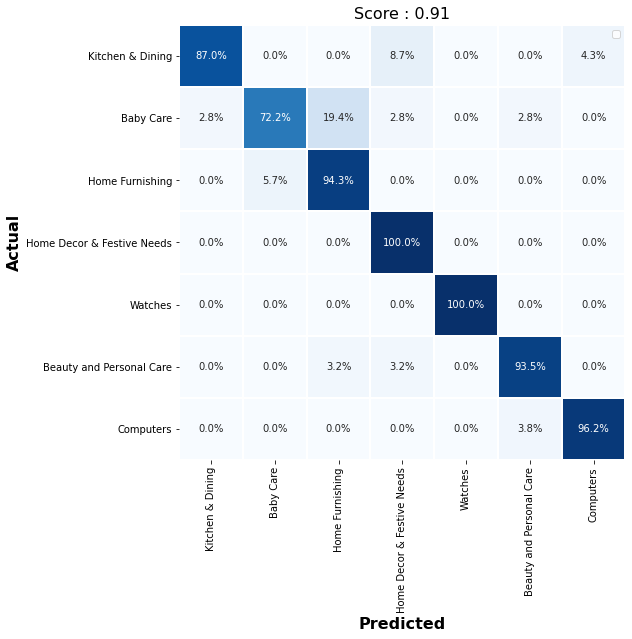

In [8]:
cm = ConfusionMatrix(y_test, y_pred, accuracy_score)
print(cm)

In [21]:
pipe = Pipeline([
    ('corpus', CorpusSelector(columns=['product_name'])),
    ('vectorizer', UniversalSentenceEncoder(use))
])

In [22]:
X = pipe.fit_transform(data)
X = pd.DataFrame(X)
X.to_csv(os.path.join(STORAGE_PATH, 'features_use.csv'), index=False)

(1050, 512)


# Unsupervized approach

In [10]:
kmeans = KMeans(n_clusters=y.nunique(), random_state=0)


param_grid = {
    'corpus__columns' : [['description'], ['product_name'], ['product_name', 'description']],
    'PCA__ratio': [0.90, 0.95, 0.99, None]
}

pipe = Pipeline(steps=[
    ('corpus', CorpusSelector(columns=None)),
    ('vectorizer', UniversalSentenceEncoder(use)),
    ('PCA', CustomPCA()),
    ('estimator', CustomClustering(kmeans))
])

display(pipe)

Pipeline(steps=[('corpus', CorpusSelector(columns=None)),
                ('vectorizer',
                 UniversalSentenceEncoder(model=<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x15ad812b0>)),
                ('PCA', CustomPCA()),
                ('estimator',
                 CustomClustering(model=KMeans(n_clusters=7, random_state=0)))])

In [ ]:
X = data 
results = pd.DataFrame()

for parameters in tqdm(ParameterGrid(param_grid)):
    print(parameters)
    pipe = pipe.set_params(**parameters)
    pipe.fit(X, y)
    y_pred = pipe.predict(X)

    score = adjusted_rand_score(y, y_pred)
    print(score)
    results = results.append({'score': score, 'parameters': parameters} , ignore_index=True)

In [30]:
best_results_parameters = results.loc[results.score == results.score.max(), 'parameters'].iloc[0]
results.loc[results.score == results.score.max()]

,score,parameters
11,0.314215,"{'PCA__ratio': None, 'corpus__columns': ['product_name', 'description']}"


In [31]:
pipe = pipe.set_params(**best_results_parameters)
pipe.fit(X, y)
y_pred = pipe.predict(X)

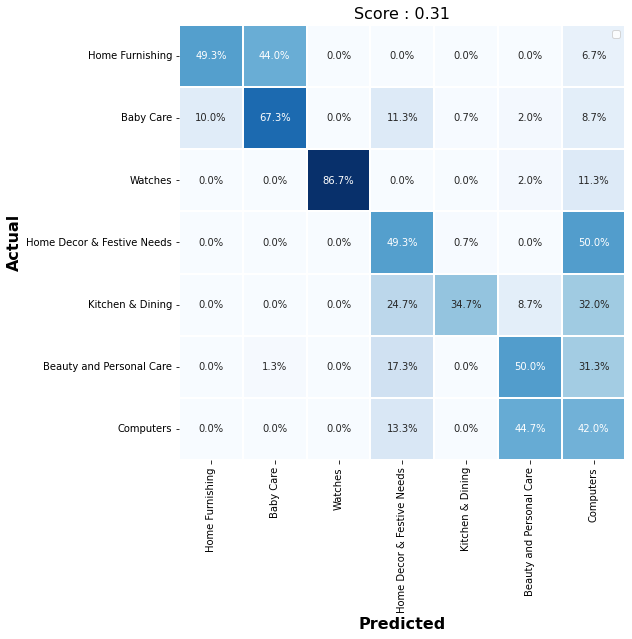

In [32]:
cm = ConfusionMatrix(y, y_pred, adjusted_rand_score)
print(cm)

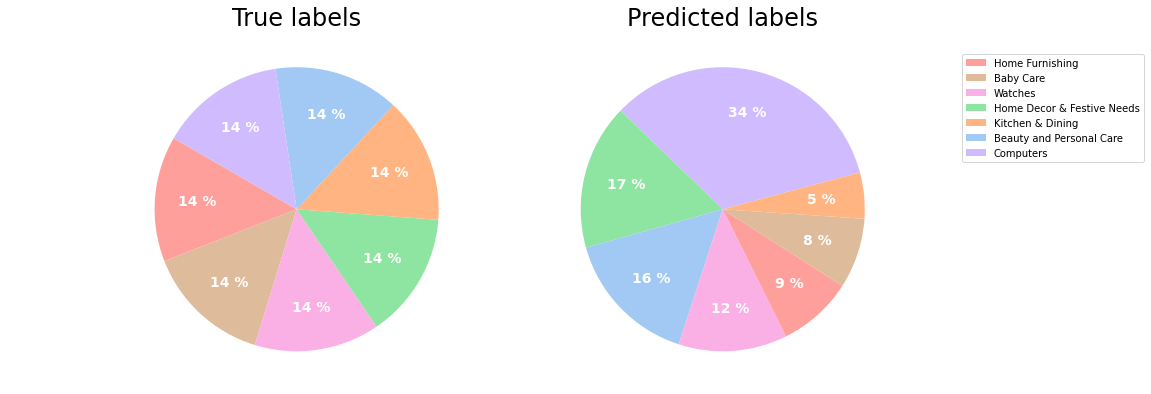

In [17]:
cd = ClusterDistribution(y, y_pred)
print(cd)